# Объединение данных и предсказание доходности
I. Загрузка предобработанных данных

II. Подготовка технических данных

III. Подготовка данных телеграма

IV. Подготовка данных Pulse

V. Объединение dataframes

VI. Обучение моделей

VII. Сравнение и анализ результатов

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import mean_squared_error

!pip install xgboost

!pip install -U pip
!pip install -U setuptools wheel
!pip install torch==1.12.1+cpu torchvision==0.13.1+cpu torchtext==0.13.1 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install autogluon


# I. Загрузка предобработанных данных

In [9]:
# Телеграм
tg = pd.read_csv("tg_2022_label.csv")

In [10]:
# Пульс
pulse = pd.read_csv('pulse_2022_label.csv')

In [11]:
# Технические сигналы
red_2022 = pd.read_excel("2022.xlsx")
red_2022.head()

,TICKER,Название компании,Отрасль,Котировальный список,Входит в индекс,Уровень ликвидности,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOLUME,VOLUME (rub),PE,PB,EMA 12,EMA 26,Сигнал 1,Быстрая MACD,Сигнальная MACD (9) - быстрая MACD,сигнал 2,Stohastic,сигнал 3,Momentum,сигнал 4,Повышения цен закрытия,Среднее повышение (7),Понижения цен закрытия,Среднее повышение (7).1,RS,RSI,сигнал 5
0,AFKS,"АФК Система, акция об.",Холдинги,Первый уровень,"Индекс МосБиржи, Индекс МосБиржи широкого рынк...",Высокий,2022-01-03,07:00:00,23.450,23.496,23.311,23.380,5519,6.513156e+04,NaN,NaN,23.311000,23.311000,NaN,0.000000,0.122771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFKS,"АФК Система, акция об.",Холдинги,Первый уровень,"Индекс МосБиржи, Индекс МосБиржи широкого рынк...",Высокий,2022-01-03,08:00:00,23.369,23.649,23.367,23.649,5114,6.060175e+04,NaN,NaN,23.319615,23.315148,NaN,0.004467,0.099110,NaN,NaN,NaN,NaN,NaN,0.056,NaN,0.0,NaN,NaN,NaN,NaN
2,AFKS,"АФК Система, акция об.",Холдинги,Первый уровень,"Индекс МосБиржи, Индекс МосБиржи широкого рынк...",Высокий,2022-01-03,09:00:00,23.650,23.765,23.580,23.661,1241800,1.487366e+07,NaN,NaN,23.359675,23.334767,NaN,0.024908,0.084270,NaN,NaN,NaN,NaN,NaN,0.213,NaN,0.0,NaN,NaN,NaN,NaN
3,AFKS,"АФК Система, акция об.",Холдинги,Первый уровень,"Индекс МосБиржи, Индекс МосБиржи широкого рынк...",Высокий,2022-01-03,10:00:00,23.661,24.249,23.644,24.217,4389800,5.281076e+07,NaN,NaN,23.403417,23.357673,NaN,0.045744,0.076565,NaN,NaN,NaN,NaN,NaN,0.064,NaN,0.0,NaN,NaN,NaN,NaN
4,AFKS,"АФК Система, акция об.",Холдинги,Первый уровень,"Индекс МосБиржи, Индекс МосБиржи широкого рынк...",Высокий,2022-01-03,11:00:00,24.210,24.295,24.051,24.051,4945000,6.059933e+07,NaN,NaN,23.503045,23.409031,NaN,0.094015,0.080055,покупать,NaN,NaN,NaN,NaN,0.407,NaN,0.0,NaN,NaN,NaN,NaN


In [342]:
print(tg.shape)
print(pulse.shape)
print(red_2022.shape)

(33247, 10)
(130006, 7)
(206693, 34)


# II. Подготовка технических данных

In [12]:
# Изменение формата данных
red_2022['DATE'] = pd.to_datetime(red_2022['DATE'], format='%Y-%m-%d')
red_2022['TIME'] = pd.to_datetime(red_2022['TIME'], format='%H:%M:%S')                           
date = red_2022.apply(lambda row: pd.to_datetime(row['DATE'].strftime('%Y-%m-%d') + ' ' + row['TIME'].strftime('%H:%M:%S')), axis=1)
red_2022.insert(0, 'date', date)

tmp = red_2022.reset_index()
# удаление лишних колонок
reduced_2022 = tmp.drop(columns=['Название компании', 'Отрасль', 'Котировальный список', 'Входит в индекс', 'Уровень ликвидности',
                                 'index', 'DATE', 'TIME'])
# переименовать Ticker
reduced_2022 = reduced_2022.rename(columns={'TICKER': 'ticker', 'Сигнал 1': 'сигнал1',
                                            'сигнал 2': 'сигнал2', 'сигнал 3': 'сигнал3',
                                           'сигнал 4': 'сигнал4', 'сигнал 5':'сигнал5'})
# обработка сигналов
def signal(row):
    if (row == 'покупать') or (row == 'покупаем'):
        return 'buy'
    elif (row == 'продавать') or (row == 'продаем'):
        return 'sell'
    else:
        return 0
reduced_2022['сигнал1'] = reduced_2022['сигнал1'].apply(signal)
reduced_2022['сигнал2'] = reduced_2022['сигнал2'].apply(signal)
reduced_2022['сигнал3'] = reduced_2022['сигнал3'].apply(signal)
reduced_2022['сигнал4'] = reduced_2022['сигнал4'].apply(signal)
reduced_2022['сигнал5'] = reduced_2022['сигнал5'].apply(signal)
# Получение дамми-переменных для сигналов
dummy_2022 = pd.get_dummies(reduced_2022, columns=['сигнал1', 'сигнал2', "сигнал3", "сигнал4", "сигнал5"])
reduced_2022 = dummy_2022.copy()
reduced_2022

,date,ticker,OPEN,HIGH,LOW,CLOSE,VOLUME,VOLUME (rub),PE,PB,EMA 12,EMA 26,Быстрая MACD,Сигнальная MACD (9) - быстрая MACD,Stohastic,Momentum,Повышения цен закрытия,Среднее повышение (7),Понижения цен закрытия,Среднее повышение (7).1,RS,RSI,сигнал1_0,сигнал1_buy,сигнал1_sell,сигнал2_0,сигнал2_buy,сигнал2_sell,сигнал3_0,сигнал3_buy,сигнал3_sell,сигнал4_0,сигнал4_buy,сигнал4_sell,сигнал5_0,сигнал5_buy,сигнал5_sell
0,2022-01-03 07:00:00,AFKS,23.450,23.496,23.311,23.380,5519,6.513156e+04,NaN,NaN,23.311000,23.311000,0.000000,0.122771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,2022-01-03 08:00:00,AFKS,23.369,23.649,23.367,23.649,5114,6.060175e+04,NaN,NaN,23.319615,23.315148,0.004467,0.099110,NaN,NaN,0.056,NaN,0.0,NaN,NaN,NaN,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,2022-01-03 09:00:00,AFKS,23.650,23.765,23.580,23.661,1241800,1.487366e+07,NaN,NaN,23.359675,23.334767,0.024908,0.084270,NaN,NaN,0.213,NaN,0.0,NaN,NaN,NaN,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,2022-01-03 10:00:00,AFKS,23.661,24.249,23.644,24.217,4389800,5.281076e+07,NaN,NaN,23.403417,23.357673,0.045744,0.076565,NaN,NaN,0.064,NaN,0.0,NaN,NaN,NaN,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,2022-01-03 11:00:00,AFKS,24.210,24.295,24.051,24.051,4945000,6.059933e+07,NaN,NaN,23.503045,23.409031,0.094015,0.080055,NaN,NaN,0.407,NaN,0.0,NaN,NaN,NaN,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206688,2022-12-23 19:00:00,YNDX,1823.000,1826.800,1812.400,1818.600,9095,8.245489e+06,NaN,NaN,1819.094983,1821.937056,-2.842073,0.082610,0.0,0.993096,1.400,0.514286,0.0,2.600000,0.197802,16.513761,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
206689,2022-12-23 20:00:00,YNDX,1817.800,1823.000,1817.600,1821.200,12422,1.129429e+07,NaN,NaN,1818.864985,1821.615792,-2.750807,-0.484073,0.0,1.003091,5.200,1.257143,0.0,2.314286,0.543210,35.200000,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
206690,2022-12-23 21:00:00,YNDX,1821.000,1823.000,1819.000,1821.000,3013,2.741642e+06,NaN,NaN,1818.885757,1821.422030,-2.536273,-0.894513,1.0,1.003863,1.400,1.457143,0.0,0.457143,3.187500,76.119403,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0
206691,2022-12-23 22:00:00,YNDX,1821.000,1822.000,1818.000,1819.800,5854,5.323969e+06,NaN,NaN,1818.749487,1821.168546,-2.419060,-1.199422,0.0,1.002647,0.000,1.457143,1.0,0.600000,2.428571,70.833333,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0


In [14]:
# Добавляем доходность
reduced_2022['return'] = reduced_2022.groupby('ticker')['CLOSE'].pct_change()
reduced_2022['vol_change'] = reduced_2022.groupby('ticker')['VOLUME'].pct_change()

In [ ]:
# Создаем контрольную точку

In [15]:
reduced_2022.to_csv('2022_reduced+dummy+return.csv', index=False)

In [16]:
reduced_2022 = pd.read_csv('2022_reduced+dummy+return.csv')

In [17]:
# Оставляем только нужные колонки
reduced_2022 = reduced_2022[['date', 'ticker', 'return', 'Быстрая MACD', 'Momentum', 'Stohastic', 'vol_change', 'RSI',
                             'сигнал1_buy', 'сигнал1_sell', 'сигнал2_buy', 'сигнал2_sell',
                             'сигнал3_buy', 'сигнал3_sell', 'сигнал4_buy', 'сигнал4_sell',
                             'сигнал5_buy', 'сигнал5_sell'
                            ]]
reduced_2022.head()

,date,ticker,return,Быстрая MACD,Momentum,Stohastic,vol_change,RSI,сигнал1_buy,сигнал1_sell,сигнал2_buy,сигнал2_sell,сигнал3_buy,сигнал3_sell,сигнал4_buy,сигнал4_sell,сигнал5_buy,сигнал5_sell
0,2022-01-03 07:00:00,AFKS,NaN,0.000000,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1,2022-01-03 08:00:00,AFKS,0.011506,0.004467,NaN,NaN,-0.073383,NaN,0,0,0,0,0,0,0,0,0,0
2,2022-01-03 09:00:00,AFKS,0.000507,0.024908,NaN,NaN,241.823621,NaN,0,0,0,0,0,0,0,0,0,0
3,2022-01-03 10:00:00,AFKS,0.023499,0.045744,NaN,NaN,2.535030,NaN,0,0,0,0,0,0,0,0,0,0
4,2022-01-03 11:00:00,AFKS,-0.006855,0.094015,NaN,NaN,0.126475,NaN,0,0,1,0,0,0,0,0,0,0


# III. Подготовка данных телеграма
label 1.0 - Отрицательное
label 2.0 - нейтральное
label 3.0 - позитивное

In [18]:
# Конвертируем даты в datetime
from datetime import datetime, timezone
import numpy as np

# convert datetime strings to datetime objects
tg['date'] = pd.to_datetime(tg['date'])

# create new datetime column without timezone information
tg['date'] = tg['date'].dt.tz_localize(None)
tg['date'].apply(lambda x: x + timedelta(hours=3))
tg_2022 = tg.loc[tg['date'] >= '2022-01-01']

In [19]:
# Создаем дамми-переменные под сентимент
tg_dummy = pd.get_dummies(tg_2022, columns=['label'])

## III.I. Создаем новые фичи

In [20]:
tg_dummy['Unnamed: 14'].unique()

array(['👍', '👎', '🔥', nan, '🐳', '🤔', '🤯', '😱', '😢', '😁', '🤬', '❤', '🎉',
       '💯', '👏', '🤣', '🌚', '🥰', '🕊', '🤡', '💩', '🖕', '🥴', '🍓', '⚡', '🤮',
       '❤\u200d🔥', '🌭', '🤩'], dtype=object)

In [21]:
# Кодируем реакции
tg_dummy['Pos_react'] = np.where((tg_dummy['Unnamed: 14'] == '👍') |
                                 (tg_dummy['Unnamed: 14'] == '🔥') |
                                 (tg_dummy['Unnamed: 14'] == '🍾') |
                                 (tg_dummy['Unnamed: 14'] == '❤') |
                                 (tg_dummy['Unnamed: 14'] == '🍓') |
                                 (tg_dummy['Unnamed: 14'] == '😁') |
                                 (tg_dummy['Unnamed: 14'] == '⚡') |
                                 (tg_dummy['Unnamed: 14'] == '😍') |
                                 (tg_dummy['Unnamed: 14'] == '🥰') |
                                 (tg_dummy['Unnamed: 14'] == '💯') |
                                 (tg_dummy['Unnamed: 14'] == '🍌') |
                                 (tg_dummy['Unnamed: 14'] == '🤣') |
                                 (tg_dummy['Unnamed: 14'] == '🐳') |
                                 (tg_dummy['Unnamed: 14'] == '🙏') |
                                 (tg_dummy['Unnamed: 14'] == '🎉') |
                                 (tg_dummy['Unnamed: 14'] == '❤\u200d🔥')
                                 , tg_dummy['Unnamed: 15'], 0)
tg_dummy['Neg_react'] = np.where((tg_dummy['Unnamed: 14'] == '🤔') |
                                 (tg_dummy['Unnamed: 14'] == '🤬') |
                                 (tg_dummy['Unnamed: 14'] == '🤡') |
                                 (tg_dummy['Unnamed: 14'] == '😱') |
                                 (tg_dummy['Unnamed: 14'] == '😢') |
                                 (tg_dummy['Unnamed: 14'] == '💩') |
                                 (tg_dummy['Unnamed: 14'] == '🖕') |
                                 (tg_dummy['Unnamed: 14'] == '🤮') |
                                 (tg_dummy['Unnamed: 14'] == '🥴') |
                                 (tg_dummy['Unnamed: 14'] == '🤯')
                                 , tg_dummy['Unnamed: 15'], 0)

In [22]:
tg_dummy = tg_dummy.drop(columns=['Unnamed: 14', 'Unnamed: 15'])

In [24]:
# Индекс RSMI
tg_dummy['RSMI_tg'] = (-tg_dummy['label_1.0'] + tg_dummy['label_3.0']) \
                * (tg_dummy['views']/1000) * (1 + (tg_dummy['Pos_react'] - tg_dummy['Neg_react']) / (tg_dummy['views']*0.21) \
                                       + tg_dummy['forwards'] / (tg_dummy['views']*0.12))

## III.II. Сммируем данные по часам, группируя по тикеру

In [25]:
#convert date column to datetime and subtract one hour
tmp = tg_dummy.copy()
tmp['date'] = pd.to_datetime(tg_dummy['date']) - pd.to_timedelta(1, unit='h')

tmp_gr = tmp.groupby([pd.Grouper(key='date', freq='h'), 'ticker']) \
                .agg({'label_1.0':'sum', 'label_2.0':'sum','label_3.0': 'sum',
                     'Neg_react': 'sum', 'Pos_react': 'sum', 'RSMI_tg': 'sum'})
tmp_gr = tmp_gr.reset_index()
tmp_gr #[(tmp_gr['label_3.0'] > 0) & (tmp_gr['label_1.0'] > 0)] #['RSMI_tg'].isna()

,date,ticker,label_1.0,label_2.0,label_3.0,Neg_react,Pos_react,RSMI_tg
0,2022-01-03 04:00:00,GAZP,0,1,0,0.0,0.0,0.0
1,2022-01-03 04:00:00,TATN,0,1,0,0.0,0.0,0.0
2,2022-01-03 05:00:00,GAZP,0,1,0,0.0,0.0,0.0
3,2022-01-03 06:00:00,SBER,0,2,0,0.0,0.0,0.0
4,2022-01-03 07:00:00,GAZP,0,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
6286,2022-12-16 09:00:00,LSNG,0,1,0,0.0,24.0,0.0
6287,2022-12-16 10:00:00,LSNG,0,1,0,0.0,96.0,0.0
6288,2022-12-16 10:00:00,MAGN,0,1,0,0.0,0.0,0.0
6289,2022-12-16 11:00:00,AFK,0,1,0,0.0,80.0,0.0


# IV. Подготовка данных Pulse

In [26]:
pulse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130006 entries, 0 to 130005
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    130006 non-null  int64  
 1   likes         130006 non-null  int64  
 2   comments      130006 non-null  int64  
 3   inserted      130006 non-null  object 
 4   content_prep  129856 non-null  object 
 5   ticker        130006 non-null  object 
 6   label         130006 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 6.9+ MB


In [27]:
# convert datetime strings to datetime objects
pulse['inserted'] = pd.to_datetime(pulse['inserted'])
pulse_dummy = pd.get_dummies(pulse, columns=['label'])
pulse_drop = pulse_dummy.drop(columns=['Unnamed: 0', 'content_prep'])

In [28]:
# Индекс RSMI
pulse_drop['RSMI_p'] = (-pulse_drop['label_1.0'] + pulse_drop['label_3.0']) \
                * (1 + pulse_drop['comments']) * (1 + pulse_drop['likes'])
pulse_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130006 entries, 0 to 130005
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   likes      130006 non-null  int64         
 1   comments   130006 non-null  int64         
 2   inserted   130006 non-null  datetime64[ns]
 3   ticker     130006 non-null  object        
 4   label_1.0  130006 non-null  uint8         
 5   label_2.0  130006 non-null  uint8         
 6   label_3.0  130006 non-null  uint8         
 7   RSMI_p     130006 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1), uint8(3)
memory usage: 5.3+ MB


In [29]:
#convert date column to datetime and subtract one hour
tmp_pulse = pulse_drop.copy()
tmp_pulse['date'] = pd.to_datetime(pulse_drop['inserted']) - pd.to_timedelta(1, unit='h')

tmp_pulse_group = tmp_pulse.groupby([pd.Grouper(key='inserted', freq='h'), 'ticker']) \
                .agg({'label_1.0':'sum', 'label_2.0':'sum','label_3.0': 'sum',
                     'likes': 'sum', 'comments': 'sum', 'RSMI_p': 'sum'})
tmp_pulse_group = tmp_pulse_group.reset_index()
tmp_pulse_group #[(tmp_gr['label_3.0'] > 0) & (tmp_gr['label_1.0'] > 0)] #['RSMI_tg'].isna()

,inserted,ticker,label_1.0,label_2.0,label_3.0,likes,comments,RSMI_p
0,2022-01-01 01:00:00,POLY,0,2,0,0,0,0
1,2022-01-01 05:00:00,SBER,0,1,0,5,10,0
2,2022-01-01 10:00:00,MAGN,0,2,0,18,0,0
3,2022-01-01 11:00:00,RUAL,0,1,0,42,8,0
4,2022-01-01 12:00:00,NKNCP,0,1,0,0,5,0
...,...,...,...,...,...,...,...,...
37435,2022-12-12 21:00:00,SBER,0,0,1,4,1,10
37436,2022-12-12 22:00:00,DSKY,0,4,0,2,3,0
37437,2022-12-12 22:00:00,GAZP,0,1,0,7,5,0
37438,2022-12-12 22:00:00,NLMK,0,1,0,7,2,0


In [30]:
tmp_pulse = tmp_pulse_group.rename(columns={'inserted': 'date', 'likes': 'likes_pulse',
                                            'comments': 'comments_pulse'})
tmp_pulse

,date,ticker,label_1.0,label_2.0,label_3.0,likes_pulse,comments_pulse,RSMI_p
0,2022-01-01 01:00:00,POLY,0,2,0,0,0,0
1,2022-01-01 05:00:00,SBER,0,1,0,5,10,0
2,2022-01-01 10:00:00,MAGN,0,2,0,18,0,0
3,2022-01-01 11:00:00,RUAL,0,1,0,42,8,0
4,2022-01-01 12:00:00,NKNCP,0,1,0,0,5,0
...,...,...,...,...,...,...,...,...
37435,2022-12-12 21:00:00,SBER,0,0,1,4,1,10
37436,2022-12-12 22:00:00,DSKY,0,4,0,2,3,0
37437,2022-12-12 22:00:00,GAZP,0,1,0,7,5,0
37438,2022-12-12 22:00:00,NLMK,0,1,0,7,2,0


# V. Объединение dataframes

In [181]:
# Берем технические данные
reduced_2022 = pd.read_csv("2022_reduced+dummy+return.csv")

In [182]:
reduced_2022['date'] = pd.to_datetime(reduced_2022['date'])
# Данные телеграма
tg_2022 = tmp_gr.sort_values('date')
# Данные пульса
pulse_2022 = tmp_pulse.sort_values('date')
reduced_2022 = reduced_2022.sort_values('date')

In [183]:
tg_2022 = tg_2022.drop(columns=['label_1.0', 'label_2.0', 'label_3.0', 'Neg_react', 'Pos_react'])
pulse_2022 = pulse_2022.drop(columns=['label_1.0', 'label_2.0', 'label_3.0'])

In [184]:
# Merge the dataframes on time using tolerance
df_merged = pd.merge_asof(reduced_2022, tg_2022,
                          on='date',
                          by='ticker',
                          #direction='backward',
                         tolerance=pd.Timedelta('1h'))
df_merged_2 = pd.merge_asof(df_merged, pulse_2022,
                          on='date',
                          by='ticker',
                          #direction='backward',
                         tolerance=pd.Timedelta('1h'))
df_merged_2

,date,ticker,OPEN,HIGH,LOW,CLOSE,VOLUME,VOLUME (rub),PE,PB,EMA 12,EMA 26,Быстрая MACD,Сигнальная MACD (9) - быстрая MACD,Stohastic,Momentum,Повышения цен закрытия,Среднее повышение (7),Понижения цен закрытия,Среднее повышение (7).1,RS,RSI,сигнал1_0,сигнал1_buy,сигнал1_sell,сигнал2_0,сигнал2_buy,сигнал2_sell,сигнал3_0,сигнал3_buy,сигнал3_sell,сигнал4_0,сигнал4_buy,сигнал4_sell,сигнал5_0,сигнал5_buy,сигнал5_sell,return,vol_change,RSMI_tg,likes_pulse,comments_pulse,RSMI_p
0,2022-01-03 07:00:00,AFKS,23.45000,23.49600,23.31100,23.38000,5519,6.513156e+04,NaN,NaN,23.311000,23.311000,0.000000,0.122771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 07:00:00,GAZP,345.01000,346.50000,344.30000,345.38000,2288650,3.943249e+08,NaN,NaN,80.545584,55.967476,24.578109,4.664911,0.0,10.541947,312.15000,44.617143,0.00000,0.088571,5.037419e+02,99.801879,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,NaN,NaN,0.0,90.0,15.0,0.0
2,2022-01-03 07:00:00,NLMK,217.14000,217.96000,216.12000,217.52000,12481,1.350517e+06,NaN,NaN,92.329910,80.280504,12.049406,2.741890,0.0,3.098050,145.86000,20.922857,0.00000,0.014286,1.464600e+03,99.931769,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-03 07:00:00,FEES,0.16334,0.16394,0.16226,0.16284,43260000,9.818434e+06,NaN,NaN,0.436156,0.460686,-0.024530,-0.004278,0.0,0.333731,0.00000,0.000600,0.32694,0.046963,1.277605e-02,1.261489,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-03 07:00:00,YNDX,4570.00000,4625.00000,4569.40000,4590.80000,26565,6.069693e+07,NaN,NaN,702.998925,338.489643,364.509281,72.901952,0.0,269501.621940,4569.38308,652.769013,0.00000,0.000007,9.138766e+07,99.999999,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206688,2022-12-23 23:00:00,HYDR,0.73510,0.73530,0.73230,0.73290,1856000,1.568908e+06,NaN,NaN,0.734549,0.736474,-0.001925,-0.001757,0.0,0.993623,0.00000,0.000300,0.00090,0.000914,3.281250e-01,24.705882,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,-0.002993,4471.289157,NaN,NaN,NaN,NaN
206689,2022-12-23 23:00:00,CBOM,6.62900,6.64300,6.62300,6.63700,1155600,4.380494e+06,NaN,NaN,6.607761,6.593451,0.014310,0.011695,0.0,1.001058,0.00300,0.007571,0.00000,0.002571,2.944444e+00,74.647887,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0.001207,180.441357,NaN,NaN,NaN,NaN
206690,2022-12-23 23:00:00,ROSN,344.20000,344.20000,343.35000,343.35000,25912,4.460859e+06,NaN,NaN,343.174716,343.005364,0.169352,0.119565,1.0,1.000291,0.10000,0.464286,0.00000,0.235714,1.969697e+00,66.326531,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,-0.002469,5.718175,NaN,NaN,NaN,NaN
206691,2022-12-23 23:00:00,MOEX,92.79000,92.97000,92.78000,92.86000,4545,2.130204e+05,NaN,NaN,92.466965,92.195687,0.271279,0.331474,1.0,1.004439,0.08000,0.125714,0.00000,0.024286,5.176471e+00,83.809524,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0.000970,7.401109,NaN,NaN,NaN,NaN


## V.I. Создаем и оставляем только лаговые переменные

In [185]:
# Выбираем нужные колонки
feature_list = ['return', 'Быстрая MACD', 'Momentum', 'Stohastic', 'vol_change', 'RSI',
                             'сигнал1_buy', 'сигнал1_sell', 'сигнал2_buy', 'сигнал2_sell',
                             'сигнал3_buy', 'сигнал3_sell', 'сигнал4_buy', 'сигнал4_sell',
                             'сигнал5_buy', 'сигнал5_sell', 'RSMI_tg', 'RSMI_p'] #'Neg_react','Pos_react',]
# Создаем нужное количество лагов и оставляем только их
laggs_list = [1,2,3]
lagged_2022 = df_merged_2[['date', 'return', 'ticker']]

for feature in feature_list:
    for lag in laggs_list:
        lagged_2022[feature+'_L{lag}'.format(lag=lag)] = df_merged_2.groupby('ticker')[feature].shift(lag)

lagged_2022 = lagged_2022.loc[lagged_2022['return_L3'].notnull()]
lagged_2022.head()

C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1750568321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_2022[feature+'_L{lag}'.format(lag=lag)] = df_merged_2.groupby('ticker')[feature].shift(lag)
C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1750568321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_2022[feature+'_L{lag}'.format(lag=lag)] = df_merged_2.groupby('ticker')[feature].shift(lag)
C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1750568321.py:10: SettingWithCopyWar

C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1750568321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_2022[feature+'_L{lag}'.format(lag=lag)] = df_merged_2.groupby('ticker')[feature].shift(lag)
C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1750568321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_2022[feature+'_L{lag}'.format(lag=lag)] = df_merged_2.groupby('ticker')[feature].shift(lag)
C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1750568321.py:10: SettingWithCopyWar

,date,return,ticker,return_L1,return_L2,return_L3,Быстрая MACD_L1,Быстрая MACD_L2,Быстрая MACD_L3,Momentum_L1,Momentum_L2,Momentum_L3,Stohastic_L1,Stohastic_L2,Stohastic_L3,vol_change_L1,vol_change_L2,vol_change_L3,RSI_L1,RSI_L2,RSI_L3,сигнал1_buy_L1,сигнал1_buy_L2,сигнал1_buy_L3,сигнал1_sell_L1,сигнал1_sell_L2,сигнал1_sell_L3,сигнал2_buy_L1,сигнал2_buy_L2,сигнал2_buy_L3,сигнал2_sell_L1,сигнал2_sell_L2,сигнал2_sell_L3,сигнал3_buy_L1,сигнал3_buy_L2,сигнал3_buy_L3,сигнал3_sell_L1,сигнал3_sell_L2,сигнал3_sell_L3,сигнал4_buy_L1,сигнал4_buy_L2,сигнал4_buy_L3,сигнал4_sell_L1,сигнал4_sell_L2,сигнал4_sell_L3,сигнал5_buy_L1,сигнал5_buy_L2,сигнал5_buy_L3,сигнал5_sell_L1,сигнал5_sell_L2,сигнал5_sell_L3,RSMI_tg_L1,RSMI_tg_L2,RSMI_tg_L3,RSMI_p_L1,RSMI_p_L2,RSMI_p_L3
199,2022-01-03 11:00:00,0.004165,SNGS,-0.007888,-0.003369,0.001875,-98.734429,-83.328182,-62.485761,0.081130,0.082109,0.082065,0.608696,1.000000,0.989362,1002.586033,0.979452,5.449799,0.868340,0.868589,0.866353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
200,2022-01-03 11:00:00,-0.006223,ROSN,0.011095,-0.002066,0.003898,116.236923,98.320089,73.975765,7.429716,7.546934,7.378213,0.000000,0.108434,0.061728,6.808083,-0.169660,0.431515,99.914048,99.657078,99.657012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
201,2022-01-03 11:00:00,0.001829,NVTK,0.006328,0.000345,0.004857,384.338201,324.387767,243.252665,405.841121,402.784223,400.277778,0.000000,0.000000,0.000000,2.651145,0.890021,-0.310961,99.998269,99.997690,99.995942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
204,2022-01-03 11:00:00,-0.001036,IRAO,0.013766,-0.001631,0.006093,0.786329,0.663540,0.497115,5.856459,5.837989,5.794837,0.000000,0.004695,0.000000,15.498798,0.019532,-0.518051,99.893189,99.848285,99.819250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
208,2022-01-03 11:00:00,0.000784,TATN,0.005321,-0.000984,0.005743,65.151378,54.919195,41.060385,2.391509,2.408551,2.365340,0.000000,0.000000,0.000000,4.320887,0.253472,-0.443335,NaN,98.998331,98.991597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN


In [186]:
# Контрольная точка
lagged_2022.to_csv('MERGED_FOR_MODELS.csv')

# VI. Обучение моделей

In [187]:
lagged_2022 = pd.read_csv('MERGED_FOR_MODELS.csv')
lagged_2022 = lagged_2022.drop(columns='Unnamed: 0')

## VI.I. Анализ корреляций

C:\Users\Матвей\AppData\Local\Temp\ipykernel_36152\3668565639.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_dataset.corr()


<AxesSubplot:>

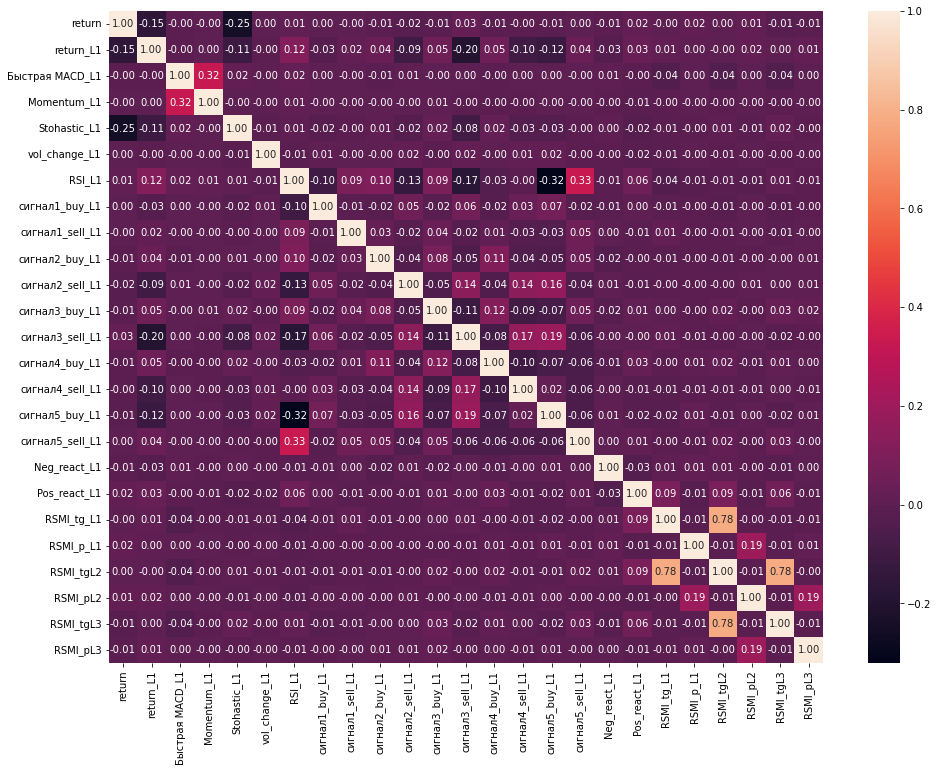

In [292]:
plt.rcParams["figure.figsize"] = (16,12)
corr = lagged_2022.corr()
#kot = corr[corr>.6]
sns.heatmap(corr, annot=True, fmt=".2f")

## VI.I. Выбор  топ-10 компаний

In [193]:
# Выбираем топ-10 компаний по обсуждаемости
lagged_2022.groupby('ticker').agg({'RSMI_p_L1': 'sum'}).sort_values('RSMI_p_L1', ascending=False)

,RSMI_p_L1
ticker,
MOEX.RENI:TQBR,0
MOEX.FLOT:TQBR,0
MOEX.LENT:TQBR,0
MOEX.POSI:TQBR,0
MOEX.SGZH:TQBR,0
MOEX.SMLT:TQBR,0
MOEX.SPBE:TQBR,0
NAUK,0
GEMA,0


## VI.II. Создание функций с моделями

In [234]:
# Датафрейм для сохранения результатов
results = pd.DataFrame()
results = pd.DataFrame(columns=['ticker', 'tp', 'algo', 'mae', 'mse', 'rmse', 'r2'])
# Функция измерения метрик моделей
def evaluate(y_true, pred, ticker, algo, tp, res=results):
    mae = metrics.mean_absolute_error(y_true, pred)
    mse = metrics.mean_squared_error(y_true, pred)
    rmse = metrics.mean_squared_error(y_true, pred, squared=False)
    r2 = metrics.r2_score(y_true, pred)
    results.loc[len(results)] = [ticker, tp, algo, mae, mse, rmse, r2]
    
# Регрессия Лассо
def Lasso_model(X_train, y_train, X_test, y_test, ticker):
    clf = Lasso().fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    evaluate(y_test, clf_pred, ticker=ticker, algo='lasso', tp='test')
    clf_pred = clf.predict(X_train)
    evaluate(y_train, clf_pred, ticker=ticker, algo='lasso',  tp='train')

# Random Forest Regressor
def RFR(X_train, y_train, X_test, y_test, ticker):
    rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)
    rfr_pred = rfr.predict(X_test)
    evaluate(y_test, rfr_pred, ticker, algo='rfr', tp='test')
    rfr_pred = rfr.predict(X_train)
    evaluate(y_train, rfr_pred, ticker, algo='rfr', tp='train')

# Gradient Boosting Regressor
def GBR(X_train, y_train, X_test, y_test, ticker):
    gbr = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
    gbr_pred = gbr.predict(X_test)
    evaluate(y_test, gbr_pred, ticker, algo='gbr',  tp='test')
    gbr_pred = gbr.predict(X_train)
    evaluate(y_train, gbr_pred,  ticker, algo='gbr', tp='train')

# Функция автоматической проверки моделей из списка: Gradient Boosting, Neural Networks, CatBoost, XGBoost, RF, XT, KNN, LR
def autoML(data, ticker):
    df_train, df_tes = train_test_split(data.drop(columns = ['ticker', 'date']), test_size=0.33, random_state=42)
    train_df = df_train #.drop(columns=['date','ticker'])
    test_df = df_tes #.drop(columns=['date','ticker'])

    hyperparameters_dict = {
        'GBM':{},
        'NN': {},
        'CAT':{},
        'XGB':{},
        'RF':{},
        'XT':{}, 
        'KNN':{},
        'LR':{}
        }

    # 1. Fit/train the models
    autogluon_predictor = TabularPredictor(label="return", eval_metric='mean_absolute_error').fit(train_data=train_df, presets='best_quality', hyperparameters=hyperparameters_dict, time_limit=None)
    # 2. Create predictions
    predictions = autogluon_predictor.predict(test_df.drop(columns='return'))
    # 3. Create the leaderboard
    autogluon_predictor.leaderboard(silent=True)
    
    #evaluate(test_df['return'], predictions, algo='wel')
    evaluate(test_df['return'], predictions, ticker, algo='wel',  tp='test')
    predictions = autogluon_predictor.predict(train_df.drop(columns='return'))
    evaluate(train_df['return'], predictions, ticker,  algo='wel', tp='train')
    best_model = autogluon_predictor.get_model_best()
    print(best_model)

# XGBoost
def XG(X_train, y_train, X_test, y_test, ticker):

    #Convert the training and testing data to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set the parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',  # Regression task with squared error loss
        'eta': 0.1,  # Learning rate
        'max_depth': 5,  # Maximum depth of each tree
        'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
        'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
        'subsample': 0.8,  # Subsample ratio of the training instance
        'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
        'verbose_eval': True  # Print evaluation results on each iteration
    }

    # Train the XGBoost model
    num_rounds = 100  # Number of boosting iterations
    model = xgb.train(params, dtrain, num_rounds)

    # Make predictions on the testing set
    y_pred = model.predict(dtest)
    #evaluate(y_test,y_pred, algo='xg')
    evaluate(y_test, y_pred, ticker, algo='xg',  tp='test')
    y_pred = model.predict(dtrain)
    evaluate(y_train, y_pred, ticker, algo='xg',  tp='train')

# LSTM model
def LSTM_model(data, ticker):
    #Extract the features and target variable
    X = data.drop(columns=['return', 'date', 'ticker'])
    y = data['return']

    features = X
    target = y

    # Normalize the features and target variable
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)
    scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
    train_features = scaled_features[:train_size]
    train_target = scaled_target[:train_size]
    test_features = scaled_features[train_size:]
    test_target = scaled_target[train_size:]

    # Reshape the data for LSTM input (samples, time steps, features)
    train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
    test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, X.shape[1])))  # 50 units in the LSTM layer
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(train_features, train_target, epochs=10, batch_size=32)

    # Make predictions on the test set
    predicted_target = model.predict(test_features)

    # Inverse transform the predictions
    predicted_target = scaler.inverse_transform(predicted_target)

    #evaluate(np.array(target[train_size:]), predicted_target, algo='LSTM')
    
    evaluate(np.array(target[train_size:]), predicted_target, ticker, algo='lstm',  tp='test')
    predicted_target = model.predict(train_features)
    predicted_target = scaler.inverse_transform(predicted_target)
    evaluate(np.array(target[:train_size]), predicted_target, ticker, algo='lstm',  tp='train')

## VI.III. Обучение и тестирование моделей c индексом RSMI
В обучающую выборку попадают 77% наблюдений за 2022 год по каждому тикеру. В тестовую - оставшиеся 33%.

In [235]:
ticker_list = ['SBER', 'GAZP', 'POLY','DSKY','PIKK','GMKN','LSRG','MGNT','YNDX','ALRS']
results = pd.DataFrame()
results = pd.DataFrame(columns=['ticker', 'tp', 'algo', 'mae', 'mse', 'rmse', 'r2'])
for ticker in ticker_list:
    #ticker = 'SBER'
    data = lagged_2022.loc[lagged_2022['ticker'] == ticker]
    data = data.fillna(0)
    #cols = list(range(51,57))
    #data.drop(data.columns[cols],axis=1,inplace=True)
    X = data.drop(columns=['return', 'date', 'ticker'])
    y = data['return']
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    Lasso_model(X_train, y_train, X_test, y_test, ticker)
    RFR(X_train, y_train, X_test, y_test, ticker)
    GBR(X_train, y_train, X_test, y_test, ticker)
    autoML(data, ticker)
    XG(X_train, y_train, X_test, y_test, ticker)
    LSTM_model(data, ticker)
results

No path specified. Models will be saved in: "AutogluonModels\ag-20230609_153708\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230609_153708\"
AutoGluon Version:  0.7.0
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    1811
Train Data Columns: 48
Label Column: return
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.4232615247237414, -0.1509497281696759, 0.00015, 0.01573)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Genera

WeightedEnsemble_L3
[18:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

Epoch 1/10
68/68 [==============================] - 2s 2ms/step - loss: 0.0460
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 4/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 5/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7/10
68/68 [==============================] - 0s 2ms/step - loss: 8.3630e-04
Epoch 8/10
68/68 [==============================] - 0s 2ms/step - loss: 7.3767e-04
Epoch 9/10
68/68 [==============================] - 0s 2ms/step - loss: 6.7266e-04
Epoch 10/10
68/68 [==============================] - 0s

No path specified. Models will be saved in: "AutogluonModels\ag-20230609_153831\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230609_153831\"
AutoGluon Version:  0.7.0
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    1811
Train Data Columns: 48
Label Column: return
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.4675986715069127, -0.2104821098605744, -6e-05, 0.01792)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generat

WeightedEnsemble_L3
[18:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

Epoch 1/10
68/68 [==============================] - 2s 3ms/step - loss: 0.0275
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 5/10
68/68 [==============================] - 0s 3ms/step - loss: 8.7650e-04
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: 7.8754e-04
Epoch 7/10
68/68 [==============================] - 0s 2ms/step - loss: 7.5134e-04
Epoch 8/10
68/68 [==============================] - 0s 3ms/step - loss: 7.3032e-04
Epoch 9/10
68/68 [==============================] - 0s 2ms/step - loss: 7.2422e-04
Epoch 10/10
68/68 [============================

No path specified. Models will be saved in: "AutogluonModels\ag-20230609_153946\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230609_153946\"
AutoGluon Version:  0.7.0
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    1802
Train Data Columns: 48
Label Column: return
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.302792198681072, -0.0999163179916319, -0.00028, 0.01448)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Genera

WeightedEnsemble_L3
[18:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

Epoch 1/10
68/68 [==============================] - 2s 2ms/step - loss: 0.0183
Epoch 2/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 4/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 5/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 7/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8/10
68/68 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 9/10
68/68 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 10/10
68/68 [==============================] - 0s 1ms/step


,ticker,tp,algo,mae,mse,rmse,r2
0,SBER,test,lasso,0.006619,0.000355,0.018836,-0.002203
1,SBER,train,lasso,0.006175,0.000247,0.015721,0.000000
2,SBER,test,rfr,0.006293,0.000343,0.018513,0.031940
3,SBER,train,rfr,0.002284,0.000037,0.006059,0.851443
4,SBER,test,gbr,0.006297,0.000368,0.019178,-0.038910
5,SBER,train,gbr,0.004119,0.000035,0.005900,0.859173
6,SBER,test,wel,0.006048,0.000341,0.018466,0.036845
7,SBER,train,wel,0.004528,0.000094,0.009676,0.621198
8,SBER,test,xg,0.006329,0.000329,0.018144,0.070158
9,SBER,train,xg,0.003644,0.000026,0.005088,0.895252


In [216]:
# Сохранение таблицы результатов
resultsRSMI = results.copy()
resultsRSMI.to_csv('results_with_RSMI.csv')
resultsRSMI = pd.read_csv('results_with_RSMI.csv')
resultsRSMI.drop(columns='Unnamed: 0')
test = resultsRSMI[resultsRSMI['tp'] == 'test']
rsm = test.copy()
rsm['index'] = test['ticker']+test['algo']
rsm = rsm.set_index('index')
rsm.shape

(60, 8)

## VI.III. Обучение и тестирование моделей без индекса RSMI
Разбиение на train and test такое же

In [ ]:
ticker_list = ['SBER', 'GAZP', 'POLY','DSKY','PIKK','GMKN','LSRG','MGNT','YNDX','ALRS']
results = pd.DataFrame()
results = pd.DataFrame(columns=['ticker', 'tp', 'algo', 'mae', 'mse', 'rmse', 'r2'])
for ticker in ticker_list:
    #ticker = 'SBER'
    data = lagged_2022.loc[lagged_2022['ticker'] == ticker]
    data = data.fillna(0)
    # Убираем колонки с RSMI 
    cols = list(range(51,57))
    data.drop(data.columns[cols],axis=1,inplace=True)
    
    X = data.drop(columns=['return', 'date', 'ticker'])
    y = data['return']
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    Lasso_model(X_train, y_train, X_test, y_test, ticker)
    RFR(X_train, y_train, X_test, y_test, ticker)
    GBR(X_train, y_train, X_test, y_test, ticker)
    autoML(data, ticker)
    XG(X_train, y_train, X_test, y_test, ticker)
    LSTM_model(data, ticker)
results

In [237]:
results.to_csv('results_no_RSMI.csv')
resultsNo = pd.read_csv('results_no_RSMI.csv')
test = resultsNo[resultsNo['tp'] == 'test']
no_rsm = test.copy()
no_rsm['index'] = test['ticker']+test['algo']
no_rsm = no_rsm.set_index('index')
resultsNo.head()

,Unnamed: 0,ticker,tp,algo,mae,mse,rmse,r2
0,0,SBER,test,lasso,0.006619,0.000355,0.018836,-0.002203
1,1,SBER,train,lasso,0.006175,0.000247,0.015721,0.000000
2,2,SBER,test,rfr,0.006291,0.000338,0.018377,0.046069
3,3,SBER,train,rfr,0.002268,0.000037,0.006046,0.852102
4,4,SBER,test,gbr,0.006341,0.000368,0.019171,-0.038160
5,5,SBER,train,gbr,0.004113,0.000035,0.005914,0.858481
6,6,SBER,test,wel,0.006048,0.000341,0.018466,0.036845
7,7,SBER,train,wel,0.004528,0.000094,0.009676,0.621198
8,8,SBER,test,xg,0.006329,0.000329,0.018144,0.070158
9,9,SBER,train,xg,0.003644,0.000026,0.005088,0.895252


# VII. Сравнение и анализ результатов

In [239]:
comparison = rsm.merge(no_rsm, on='index',suffixes=("_1", "_0"))
# Считаем разницу прироста как (Без_RSMI-С_RSMI) / Без_RSMI
comparison['mae_change'] = (comparison['mae_0'] - comparison['mae_1']) / comparison['mae_0'] * 100
comparison['mse_change'] = (comparison['mse_0'] - comparison['mse_1']) / comparison['mse_0'] * 100
comparison['rmse_change'] = (comparison['rmse_0'] - comparison['rmse_1']) / comparison['rmse_0'] * 100

In [325]:
print('Средняя ошибка по каждому алгоритму без RSMI')
file2 = comparison[['ticker_1','algo_1','mae_0','mse_0','rmse_0']].groupby(['algo_1']).mean() #.sort_values('rmse_0')
#file2.to_excel('table1.xlsx')
file2

Средняя ошибка по каждому алгоритму без RSMI


C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\1339127605.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  file2 = comparison[['ticker_1','algo_1','mae_0','mse_0','rmse_0']].groupby(['algo_1']).mean() #.sort_values('rmse_0')


,mae_0,mse_0,rmse_0
algo_1,,,
gbr,0.006444,0.000287,0.016733
lasso,0.006520,0.000244,0.015297
lstm,0.005960,0.000071,0.008163
rfr,0.006400,0.000259,0.015900
wel,0.005962,0.000232,0.014966
xg,0.006531,0.000332,0.017952


In [323]:
print('Средняя ошибка по каждому алгоритму с RSMI')
file1 = comparison[['ticker_1','algo_1','mae_1','mse_1','rmse_1']].groupby(['algo_1']).mean() #.sort_values('mae_1')
#file1.to_excel('table2.xlsx')
file1

Средняя ошибка по каждому алгоритму с RSMI


C:\Users\Матвей\AppData\Local\Temp\ipykernel_9168\3104090142.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  file1 = comparison[['ticker_1','algo_1','mae_1','mse_1','rmse_1']].groupby(['algo_1']).mean() #.sort_values('mae_1')


,mae_1,mse_1,rmse_1
algo_1,,,
gbr,0.006482,0.000288,0.016741
lasso,0.006574,0.000256,0.015584
lstm,0.005929,0.000071,0.008053
rfr,0.006408,0.000263,0.016043
wel,0.005996,0.000234,0.015023
xg,0.006568,0.000330,0.017917


In [320]:
print('Средняя ошибка по каждому алгоритму с RSMI')
file3 = comparison[['ticker_1', 'algo_1','mae_1','mse_1','rmse_1']].groupby(['ticker_1']).apply(lambda x: x.sort_values(['mae_1'], ascending=True))
#file3.to_excel('table3.xlsx')
file3

Средняя ошибка по каждому алгоритму с RSMI


ticker_1 algo_1     mae_1     mse_1    rmse_1
ticker_1 index                                                  
ALRS     ALRSlstm      ALRS   lstm  0.004472  0.000037  0.006064
         ALRSwel       ALRS    wel  0.005647  0.000187  0.013662
         ALRSlasso     ALRS  lasso  0.005947  0.000179  0.013374
         ALRSrfr       ALRS    rfr  0.005954  0.000239  0.015461
         ALRSgbr       ALRS    gbr  0.006017  0.000258  0.016049
         ALRSxg        ALRS     xg  0.006121  0.000286  0.016908
DSKY     DSKYwel       DSKY    wel  0.006165  0.000359  0.018938
         DSKYrfr       DSKY    rfr  0.006333  0.000339  0.018419
         DSKYgbr       DSKY    gbr  0.006462  0.000376  0.019385
         DSKYxg        DSKY     xg  0.006498  0.000362  0.019026
         DSKYlasso     DSKY  lasso  0.007126  0.000512  0.022618
         DSKYlstm      DSKY   lstm  0.008815  0.000215  0.014660
GAZP     GAZPwel       GAZP    wel  0.005833  0.000326  0.018043
         GAZPlasso     GAZP  lasso  0.006194  0.000310  0.017597
         GAZPlstm      GAZP   lstm  0.006626  0.000070  0.008387
         GAZPrfr       GAZP    rfr  0.006654  0.000427  0.020676
         GAZPxg        GAZP     xg  0.006925  0.000646  0.025424
         GAZPgbr       GAZP    gbr  0.006989  0.000522  0.022858
GMKN     GMKNlstm      GMKN   lstm  0.004220  0.000029  0.005393
         GMKNwel       GMKN    wel  0.004315  0.000084  0.009164
         GMKNlasso     GMKN  lasso  0.004670  0.000072  0.008500
         GMKNrfr       GMKN    rfr  0.004738  0.000138  0.011731
         GMKNgbr       GMKN    gbr  0.004761  0.000174  0.013201
         GMKNxg        GMKN     xg  0.004781  0.000177  0.013292
LSRG     LSRGwel       LSRG    wel  0.006326  0.000225  0.014989
         LSRGlasso     LSRG  lasso  0.006614  0.000230  0.015180
         LSRGlstm      LSRG   lstm  0.006820  0.000078  0.008836
         LSRGrfr       LSRG    rfr  0.006992  0.000244  0.015635
         LSRGxg        LSRG     xg  0.007027  0.000276  0.016603
         LSRGgbr       LSRG    gbr  0.007268  0.000255  0.015979
MGNT     MGNTlstm      MGNT   lstm  0.004275  0.000031  0.005544
         MGNTwel       MGNT    wel  0.005249  0.000162  0.012729
         MGNTgbr       MGNT    gbr  0.005544  0.000215  0.014653
         MGNTrfr       MGNT    rfr  0.005579  0.000206  0.014344
         MGNTlasso     MGNT  lasso  0.005722  0.000165  0.012855
         MGNTxg        MGNT     xg  0.006173  0.000377  0.019421
PIKK     PIKKlstm      PIKK   lstm  0.005805  0.000057  0.007578
         PIKKwel       PIKK    wel  0.006989  0.000252  0.015860
         PIKKgbr       PIKK    gbr  0.007252  0.000223  0.014947
         PIKKxg        PIKK     xg  0.007275  0.000236  0.015361
         PIKKrfr       PIKK    rfr  0.007309  0.000234  0.015284
         PIKKlasso     PIKK  lasso  0.007472  0.000281  0.016765
POLY     POLYlstm      POLY   lstm  0.005967  0.000063  0.007950
         POLYwel       POLY    wel  0.006698  0.000193  0.013907
         POLYgbr       POLY    gbr  0.006987  0.000217  0.014745
         POLYrfr       POLY    rfr  0.007113  0.000222  0.014911
         POLYxg        POLY     xg  0.007212  0.000289  0.017001
         POLYlasso     POLY  lasso  0.007523  0.000213  0.014587
SBER     SBERlstm      SBER   lstm  0.005674  0.000061  0.007806
         SBERwel       SBER    wel  0.006081  0.000333  0.018247
         SBERxg        SBER     xg  0.006326  0.000339  0.018405
         SBERrfr       SBER    rfr  0.006354  0.000352  0.018773
         SBERgbr       SBER    gbr  0.006380  0.000395  0.019886
         SBERlasso     SBER  lasso  0.006749  0.000363  0.019041
YNDX     YNDXlstm      YNDX   lstm  0.006615  0.000069  0.008314
         YNDXwel       YNDX    wel  0.006662  0.000216  0.014689
         YNDXrfr       YNDX    rfr  0.007052  0.000231  0.015195
         YNDXgbr       YNDX    gbr  0.007163  0.000247  0.015707
         YNDXxg        YNDX     xg  0.007342  0.000314  0.017725
         YNDXlasso     YNDX  lasso  0.007725  0.000235

In [328]:
print('Процентное уменьшение ошибок для LSTM')
change = comparison.loc[(comparison['algo_1'] == 'lstm')] #| (comparison['algo_1'] == 'wel')]
file4 = change[['ticker_1','algo_1','mae_change','mse_change','rmse_change']].groupby(['ticker_1']).max()
#file4.to_excel('table4.xlsx')
file4

Процентное уменьшение ошибок для LSTM


,algo_1,mae_change,mse_change,rmse_change
ticker_1,,,,
ALRS,gbr,-1.111695,-5.515800,-2.720884
DSKY,gbr,-1.168906,-1.798644,-0.895314
GAZP,gbr,-2.451443,0.104664,0.052346
GMKN,gbr,0.357700,-1.832634,-0.912157
LSRG,gbr,-2.612103,-13.149435,-6.371723
MGNT,gbr,0.370926,8.354926,4.268566
PIKK,gbr,-0.864020,-0.829371,-0.413829
POLY,gbr,1.546962,14.049242,7.290368
SBER,gbr,-0.611076,-7.590294,-3.725741


In [339]:
print('Процентное уменьшение ошибок для LSTM')
#change = comparison.loc[(comparison['algo_1'] == 'lstm')] #| (comparison['algo_1'] == 'wel')]
file4 = comparison[['ticker_1','algo_1','mae_change','mse_change','rmse_change']].groupby(['algo_1', 'ticker_1']).max().sort_values('mae_change')
#file4.to_excel('table4.xlsx')
file4

Процентное уменьшение ошибок для LSTM


mae_change  mse_change  rmse_change
algo_1 ticker_1                                     
lstm   GAZP      -20.375826  -23.033072   -10.920274
       LSRG      -18.664680  -31.328355   -14.598584
       DSKY      -10.622016   -8.297165    -4.065924
       PIKK      -10.207168  -17.864053    -8.565212
lasso  DSKY       -5.496789  -28.324880   -13.280572
xg     GMKN       -2.656330   -1.796903    -0.894451
gbr    LSRG       -2.612103  -13.149435    -6.371723
       GAZP       -2.451443    0.104664     0.052346
xg     ALRS       -2.337041    0.111505     0.055768
lasso  SBER       -1.970964   -2.182090    -1.085157
xg     DSKY       -1.667101    0.046708     0.023356
wel    ALRS       -1.536725   -1.373189    -0.684254
xg     YNDX       -1.510912    1.934937     0.972194
wel    MGNT       -1.414367    1.138347     0.570803
gbr    DSKY       -1.168906   -1.798644    -0.895314
wel    GMKN       -1.166024   -8.156772    -3.998448
gbr    ALRS       -1.111695   -5.515800    -2.720884
rfr    SBER       -0.995679   -4.354118    -2.153863
xg     MGNT       -0.887458   -3.782323    -1.873609
gbr    PIKK       -0.864020   -0.829371    -0.413829
rfr    GMKN       -0.828832   -9.547876    -4.665121
       MGNT       -0.665244   -1.750917    -0.871660
gbr    SBER       -0.611076   -7.590294    -3.725741
wel    PIKK       -0.583372    0.602528     0.301719
       SBER       -0.554667    2.359362     1.186722
       LSRG       -0.548685   -0.638897    -0.318940
rfr    LSRG       -0.433011    0.436602     0.218540
wel    DSKY       -0.391798   -1.528650    -0.761426
xg     GAZP       -0.341508    3.732474     1.883984
lasso  YNDX       -0.320300   -0.239461    -0.119659
wel    GAZP       -0.313500   -0.158353    -0.079145
lasso  ALRS       -0.142648   -0.038278    -0.019137
       GAZP       -0.085716   -0.008083    -0.004041
wel    YNDX       -0.025595   -4.585918    -2.267257
lasso  POLY       -0.020679    0.045546     0.022776
       LSRG       -0.004706   -0.001401    -0.000701
       PIKK       -0.002539   -0.000439    -0.000219
       MGNT        0.000000    0.000000     0.000000
xg     SBER        0.048002   -2.904097    -1.441657
rfr    ALRS        0.054498   -0.897990    -0.447991
lasso  GMKN        0.075820    0.058614     0.029311
rfr    YNDX        0.090965   -2.922594    -1.450773
       POLY        0.249245   -0.824331    -0.411320
       DSKY        0.256923   -0.305918    -0.152842
wel    POLY        0.303598    0.916522     0.459316
rfr    PIKK        0.307596    1.643069     0.824937
xg     LSRG        0.318303   -7.109772    -3.493851
       POLY        0.324100    5.025144     2.544956
rfr    GAZP        0.324324   -1.653581    -0.823400
gbr    GMKN        0.357700   -1.832634    -0.912157
       MGNT        0.370926    8.354926     4.268566
       YNDX        0.940635    6.651125     3.382778
       POLY        1.546962   14.049242     7.290368
xg     PIKK        1.869881    6.593131     3.352771
lstm   ALRS        3.568640   20.349578    10.752915
       YNDX        6.091004   13.342893     6.910201
       SBER        8.746882    3.622840     1.828130
       POLY       14.894028   23.015147    12.258987
       MGNT       15.374553   19.692331    10.385454
       GMKN       18.044415   28.282185    15.313629

# Песочиница: Каждый алгоритм отдельно для проверки гипотез

In [352]:
Для одного стока
lagged_2022 lagged_2022.fillna(0)
X = lagged_2022.drop(columns=['return', 'date', 'ticker'])
y = data['return']
print(X.shape)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(17000, 16)

In [354]:
def evaluate(y_true, pred):
    print('MAE:', metrics.mean_absolute_error(y_true, pred))
    print('MSE:', metrics.mean_squared_error(y_true, pred))
    print('RMSE:', metrics.mean_squared_error(y_true, pred, squared=False))
    print('R2:', metrics.r2_score(y_true, pred))

In [355]:
import statsmodels.api as sm
model = sm.OLS(y_train,X_train)
#y_pred = model.predict(y_test)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 return   R-squared (uncentered):                   0.103
Model:                            OLS   Adj. R-squared (uncentered):              0.103
Method:                 Least Squares   F-statistic:                              122.5
Date:                Thu, 08 Jun 2023   Prob (F-statistic):                        0.00
Time:                        19:00:18   Log-Likelihood:                          45115.
No. Observations:               17000   AIC:                                 -9.020e+04
Df Residuals:                   16984   BIC:                                 -9.007e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
return_L1          -0.1981      0.008    -26.204      0.000      -0.213      -0.183
Быстрая MACD_L1 -4.974e-07   4.77e-07     -1.044      0.297   -1.43e-06    4.37e-07
Momentum_L1        2.1e-10   2.82e-08      0.007      0.994    -5.5e-08    5.54e-08
Stohastic_L1       -0.0105      0.000    -36.765      0.000      -0.011      -0.010
vol_change_L1   -7.679e-06   1.23e-06     -6.248      0.000   -1.01e-05   -5.27e-06
RSI_L1           8.773e-05   3.64e-06     24.078      0.000    8.06e-05    9.49e-05
сигнал1_buy_L1      0.0013      0.001      0.977      0.328      -0.001       0.004
сигнал1_sell_L1    -0.0022      0.001     -1.696      0.090      -0.005       0.000
сигнал2_buy_L1      0.0008      0.001      1.088      0.277      -0.001       0.002
сигнал2_sell_L1    -0.0032      0.001     -4.327      0.000      -0.005      -0.002
сигнал3_buy_L1      0.0005      0.000      0.968      0.333      -0.000       0.001
сигнал3_sell_L1     0.0018      0.000      3.717      0.000       0.001       0.003
сигнал4_buy_L1      0.0016      0.000      3.376      0.001       0.001       0.002
сигнал4_sell_L1  5.137e-05      0.000      0.108      0.914      -0.001       0.001
сигнал5_buy_L1      0.0006      0.001      1.166      0.244      -0.000       0.002
сигнал5_sell_L1    -0.0021      0.001     -3.116      0.002      -0.003      -0.001
==============================================================================
Omnibus:                     7518.672   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19331657.060
Skew:                           0.293   Prob(JB):                         0.00
Kurtosis:                     168.201   Cond. No.                     2.69e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [356]:
clf = Lasso(random_state=0).fit(X_train, y_train)
clf_pred = clf.predict(X_test)
evaluate(y_test, clf_pred)

MAE: 0.004429429538557177
MSE: 6.918950927018309e-05
RMSE: 0.008318023158790981
R2: -5.694805327749464e-06


In [357]:
rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
evaluate(y_test, rfr_pred)

MAE: 0.004701378780981958
MSE: 7.663761434114861e-05
RMSE: 0.008754291195816404
R2: -0.10765420344540422


In [358]:
gbr = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
evaluate(y_test, gbr_pred)

MAE: 0.004557445396814663
MSE: 6.447704220935073e-05
RMSE: 0.008029759785283164
R2: 0.0681042534675056


In [ ]:
# res = pd.DataFrame()
# res['true'] = y_test
# res['gbr'] = gbr_pred
# res = res.sort_index()
# plt.scatter(res.index, res['true'])
# plt.scatter(res.index, res['gbr'])

# AutoML

In [256]:
# !pip install -U pip
# !pip install -U setuptools wheel

# !pip install torch==1.12.1+cpu torchvision==0.13.1+cpu torchtext==0.13.1 -f https://download.pytorch.org/whl/cpu/torch_stable.html

# !pip install autogluon

In [359]:
df_train, df_test = train_test_split(data.drop(columns = ['ticker', 'date']), test_size=0.2, random_state=42, shuffle=False)
#tmp = scaler.fit_transform(df_train)
#tmp2 = scaler.fit_transform(df_test)
df_train_sc = pd.DataFrame(df_train, index=df_train.index, columns=df_train.columns)
df_test_sc = pd.DataFrame(df_test, index=df_test.index, columns=df_train.columns)
df_train_sc['return'] = df_train['return']
df_test_sc['return'] = df_test['return']
df_train_sc

In [360]:
from autogluon.tabular import TabularDataset, TabularPredictor
hyperparameters_dict = {
    'GBM':{},
    'NN': {},
    'CAT':{},
    'XGB':{},
    'RF':{},
    'XT':{}, 
    'KNN':{},
    'LR':{}
    }

# 1. Fit/train the models
autogluon_predictor = TabularPredictor(label="return", eval_metric='mean_absolute_error').fit(train_data=train_df, presets='best_quality', hyperparameters=hyperparameters_dict, time_limit=None)

# 2. Create predictions
predictions = autogluon_predictor.predict(test_df.drop(columns='return'))

# 3. Create the leaderboard
autogluon_predictor.leaderboard(silent=True)

No path specified. Models will be saved in: "AutogluonModels\ag-20230608_160219\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230608_160219\"
AutoGluon Version:  0.7.0
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    17000
Train Data Columns: 16
Label Column: return
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.4675986715069127, -0.4319272543571609, -0.00013, 0.01799)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Gene

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.006453,2.079409,54.799810,0.000000,0.262554,3,True,13
1,WeightedEnsemble_L2,-0.006485,0.603284,24.050256,0.001019,0.331285,2,True,7
2,CatBoost_BAG_L2,-0.006502,1.150897,39.677696,0.031743,10.892364,2,True,9
3,CatBoost_BAG_L1,-0.006564,0.029426,13.661086,0.029426,13.661086,1,True,3
4,XGBoost_BAG_L1,-0.006573,0.077788,8.671074,0.077788,8.671074,1,True,5
5,XGBoost_BAG_L2,-0.006687,1.208911,39.749541,0.089757,10.964209,2,True,11
6,ExtraTrees_BAG_L2,-0.006755,1.592886,31.303587,0.473733,2.518255,2,True,10
7,RandomForest_BAG_L2,-0.006843,1.573934,41.126637,0.454780,12.341305,2,True,8
8,ExtraTrees_BAG_L1,-0.006951,0.373010,1.345921,0.373010,1.345921,1,True,4
9,RandomForest_BAG_L1,-0.006997,0.433071,4.579666,0.433071,4.579666,1,True,2


In [361]:
predictions = autogluon_predictor.predict(X_test)
evaluate(df_test_sc['return'], predictions)

MAE: 0.004241789271664188
MSE: 6.246198997951267e-05
RMSE: 0.007903289820037771
R2: 0.09722808634944535


In [260]:
# autogluon_predictor.delete_models(models_to_keep='best', dry_run=False)
# autogluon_predictor.save('WeightedEnsemble_L3_red_data')

In [332]:
best_model = autogluon_predictor.get_model_best()
print(autogluon_predictor.feature_importance(train_df))
#print(autogluon_predictor.fit_summary())
#best_model_params = autogluon_predictor.get_model_hyperparams(best_model)
print(best_model)

Computing feature importance via permutation shuffling for 24 features using 5000 rows with 5 shuffle sets...
	242.08s	= Expected runtime (48.42s per shuffle set)
	71.21s	= Actual runtime (Completed 5 of 5 shuffle sets)


                   importance        stddev       p_value  n  p99_high  \
Stohastic_L1     2.821011e-03  1.238177e-04  4.442002e-07  5  0.003076   
return_L1        1.412247e-03  1.123955e-04  4.773920e-06  5  0.001644   
Momentum_L1      8.710267e-04  6.654309e-05  4.055974e-06  5  0.001008   
RSI_L1           4.473586e-04  4.148338e-05  8.771858e-06  5  0.000533   
vol_change_L1    3.395085e-04  3.199761e-05  9.356693e-06  5  0.000405   
Быстрая MACD_L1  2.519381e-04  1.199171e-05  6.140727e-07  5  0.000277   
сигнал3_sell_L1  6.729722e-05  5.461939e-06  5.161493e-06  5  0.000079   
сигнал5_buy_L1   3.938662e-05  3.771223e-06  9.963800e-06  5  0.000047   
RSMI_p_L1        3.890963e-05  5.960164e-06  6.405002e-05  5  0.000051   
RSMI_pL2         3.670468e-05  1.281290e-05  1.525537e-03  5  0.000063   
сигнал4_sell_L1  3.609945e-05  3.066807e-06  6.190951e-06  5  0.000042   
RSMI_pL3         2.989042e-05  6.931825e-06  3.235380e-04  5  0.000044   
сигнал4_buy_L1   2.733480e-05  5.40284

# Xgboost

In [262]:
#!pip install xgboost

In [362]:


#X = data.drop(columns=['return', 'date', 'ticker'])
#y = data['return']

#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert the training and testing data to DMatrix format
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)
dtrain = xgb.DMatrix(train_df.drop(columns='return'), label=train_df['return'])
dtest = xgb.DMatrix(test_df.drop(columns='return'), label=test_df['return'])

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eta': 0.1,  # Learning rate
    'max_depth': 5,  # Maximum depth of each tree
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'subsample': 0.8,  # Subsample ratio of the training instance
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'verbose_eval': True  # Print evaluation results on each iteration
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting iterations
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing set
y_pred = model.predict(dtest)


[19:04:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose_eval" } are not used.



In [363]:
#evaluate(y_test,y_pred)
evaluate(test_df['return'],y_pred)

MAE: 0.004538817148093803
MSE: 6.699559517410526e-05
RMSE: 0.008185083699883909
R2: 0.03170325374963745


# LSTM

In [346]:
top_10[top_10['ticker'] == 'SBER']

,date,return,ticker,return_L1,Быстрая MACD_L1,Momentum_L1,Stohastic_L1,vol_change_L1,RSI_L1,сигнал1_buy_L1,сигнал1_sell_L1,сигнал2_buy_L1,сигнал2_sell_L1,сигнал3_buy_L1,сигнал3_sell_L1,сигнал4_buy_L1,сигнал4_sell_L1,сигнал5_buy_L1,сигнал5_sell_L1,Neg_react_L1,Pos_react_L1,RSMI_tg_L1,RSMI_p_L1,RSMI_tgL2,RSMI_pL2,RSMI_tgL3,RSMI_pL3
34,2022-01-03 09:00:00,0.000169,SBER,0.004914,36.026592,7.418868,0.000000,0.216678,99.956907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN
40,2022-01-03 10:00:00,0.012306,SBER,0.000169,48.012045,7.441147,0.000000,-0.092032,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
86,2022-01-03 11:00:00,0.002664,SBER,0.012306,56.902277,7.446621,0.000000,7.193091,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
134,2022-01-03 12:00:00,-0.000166,SBER,0.002664,63.431294,7.483363,0.000000,-0.029591,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2022-01-03 13:00:00,0.003987,SBER,-0.000166,67.918685,7.513135,0.091575,-0.682698,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206356,2022-12-23 19:00:00,-0.001886,SBER,-0.001882,0.058166,1.002330,0.001047,-0.603663,68.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206401,2022-12-23 20:00:00,0.001381,SBER,-0.001886,0.065370,1.001894,0.000000,-0.964310,56.692913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206421,2022-12-23 21:00:00,-0.000726,SBER,0.001381,0.075852,1.004673,0.000000,-0.183257,63.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206449,2022-12-23 22:00:00,0.001234,SBER,-0.000726,0.092774,1.004449,0.000408,-0.930683,85.849057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
N = int(1700)
train_data = pd.DataFrame()
tmp_data = pd.DataFrame()
target = top_10['return']

for ticker in total.keys():
    tmp = top_10[top_10['ticker'] == ticker].drop(columns=['ticker', 'date', 'return'])
    scaler = MinMaxScaler(feature_range=(0, 1))
for ticker, dates in total.items():
    train_dates = dates[:N]
    train_data = train_data.append(pd.DataFrame({'ticker': ticker, 'date': train_dates}))
train_dataset = pd.merge(train_data, top_10, on=['ticker', 'date'], how='inner')

test_dataset = top_10[~top_10.set_index(['ticker', 'date']).index.isin(train_dataset.set_index(['ticker', 'date']).index)]
test_dataset = test_dataset.sort_values(['ticker', 'date'])
train_dataset.shape

In [343]:


# Extract the features and target variable
#data = data.loc[data.ticker=='SBER']
#X = data.drop(columns=['return', 'date', 'ticker'])
#y = data['return']

# features = X
# target = y

# # Normalize the features and target variable
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features)
# scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

# # Split the data into training and testing sets
# train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
# train_features = scaled_features[:train_size]
# train_target = scaled_target[:train_size]
# test_features = scaled_features[train_size:]
# test_target = scaled_target[train_size:]

features = train_dataset.drop(columns=['date','ticker','return'])
target = 

# Normalize the features and target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

train_features = X_train
train_target = y_train
test_features = X_test
test_target = y_test

# Reshape the data for LSTM input (samples, time steps, features)
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, 24)))  # 50 units in the LSTM layer
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_features, train_target, epochs=10, batch_size=32)

# Make predictions on the test set
predicted_target = model.predict(test_features)

# Inverse transform the predictions
predicted_target = scaler.inverse_transform(predicted_target)



ValueError: Must pass 2-d input. shape=(17000, 1, 24)

In [267]:
# Evaluate the model
evaluate(np.array(target[train_size:]), predicted_target)
mse = np.mean(abs(predicted_target - np.array(target[train_size:])))
r2 = metrics.r2_score(np.array(target[train_size:]), predicted_target)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

MAE: 0.004441196862511263
MSE: 3.6655681319077816e-05
RMSE: 0.006054393555020834
R2: -0.9486744880580325
Mean Squared Error: 0.0050075059909347715
R-squared: -0.9486744880580325


In [ ]:
#!pip install autokeras

In [278]:
import numpy as np
import autokeras as ak
from autokeras import StructuredDataRegressor

# define the search
search = ak.StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')
# perform the search
search.fit(x=X_train, y=y_train, epochs=10)
# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)
# use the model to make a prediction
X_new = asarray([[108]]).astype('float32')
yhat = search.predict(X_new)
print('Predicted: %.3f' % yhat[0])
# get the best performing model
model = search.export_model()
# summarize the loaded model
model.summary()
# save the best performing model to file
model.save('model_insurance.h5')

FailedPreconditionError: . is not a directory

In [287]:
df = data.loc[data['ticker']=='SBER'].copy()
# Preprocessing
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'return'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['return'][i] = data['return'][i]

KeyError: 0

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Loading data

df = data.loc[data['ticker']=='SBER'].copy()
# Preprocessing
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'return'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['return'][i] = data['return'][i]

# Setting index
new_data.index = new_data.Date
new_data.drop('date', axis=1, inplace=True)

# Creating train and test sets
dataset = new_data.values
train = dataset[0:987,:]
valid = dataset[987:,:]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Creating a data structure with 60 timestamps and 1 output
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Building the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# Predicting data, we start from 60 because we need 60 previous data to predict the next one
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# Plotting the results
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['return'])
plt.plot(valid[['return','Predictions']])
plt.show()

KeyError: 0